<a href="https://colab.research.google.com/github/tmogoa/melamine/blob/main/MelamineSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),# same convolution
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),# same convolution
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

In [4]:
class UNET(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=1,
        features=[64, 128, 256, 512]
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of U-Net
        for feature in features:
            self.downs.append(
                DoubleConv(in_channels, feature)
            )
            in_channels = feature

        #Up part
        # Transposed convolution: https://towardsdatascience.com/transposed-convolution-demystified-84ca81b4baba
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2,
                    feature,
                    kernel_size=2,
                    stride=2
                )
            )
            self.ups.append(
                DoubleConv(
                    feature * 2,
                    feature
                )
            )
        self.bottleneck = DoubleConv(
            features[-1],
            features[-1] * 2,

        )

        self.final_conv = nn.Conv2d(
            features[0],
            out_channels,
            kernel_size=1
        )
    
    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
        x = self.bottleneck(x)
        # reversing list of skip connections
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                #resize to allow concat with skip connection
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat(
                (skip_connection, x),
                dim=1
            )
            x = self.ups[idx+1](concat_skip)
        return self.final_conv(x)

In [ ]:
def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    print(preds.shape)
    print(x.shape)
    assert preds.shape == x.shape

In [ ]:
test()

torch.Size([3, 1, 161, 161])
torch.Size([3, 1, 161, 161])


## Data Loading

In [5]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(
            self.mask_dir,
            self.images[index].replace("orig.jpg", "contour.png")
        )
        image = np.array(
            Image.open(img_path).convert("RGB")
        )
        mask = np.array(
            Image.open(mask_path).convert("L"),
            dtype=np.float32
        )
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        return image, mask, img_path

# Train

In [7]:
# install albumentation lib
!pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 123 kB 7.0 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim

### Hyperparameters

In [10]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
NUM_EPOCHS = 30
NUM_WORKERS = 2
IMAGE_HEIGHT = 350
IMAGE_WIDTH = 350
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "/content/drive/Shareddrives/Melamine/seg_dataset/train"
TRAIN_MASK_DIR = "/content/drive/Shareddrives/Melamine/seg_dataset/train_masks"
VAL_IMG_DIR = "/content/drive/Shareddrives/Melamine/seg_dataset/val"
VAL_MASK_DIR = "/content/drive/Shareddrives/Melamine/seg_dataset/val_masks"

## Utils

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
def save_checkpoint(
    state, 
    filename=f"/content/drive/Shareddrives/Melamine/seg_dataset/{NUM_EPOCHS}-checkpoint.pth.tar"
):
    print("=> Saving checkpoint")
    torch.save(state, filename)
def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [13]:
def get_loaders(
    train_dir,
    train_mask_dir,
    val_dir,
    val_mask_dir,
    batch_size,
    train_transform, 
    val_transform,
    num_workers=4,
    pin_memory=True
):
    train_ds = SegmentationDataset(
        image_dir=train_dir,
        mask_dir=train_mask_dir,
        transform=train_transform
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True
    )

    val_ds = SegmentationDataset(
        image_dir=val_dir,
        mask_dir=val_mask_dir,
        transform=val_transform
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False
    )

    return train_loader, val_loader

In [14]:
def dice_score_fn(loader, model, device="cuda"):
    model.eval()
    list_preds = []
    list_y = []
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(X))
            preds = (preds > 0.5).float()
            list_preds.append(preds)
            list_y.append(y)
    model.train()
    all_preds = list_preds[0]
    all_y = list_y[0]
    for i in range(1, len(list_preds)):
        all_preds = torch.cat((all_preds, list_preds[i]))
        all_y = torch.cat((all_y, list_y[i]))
        print(all_preds.shape)
        print(len(loader))
    dice_score = ( (2 * (all_preds * all_y).sum() + 1e-8) / ((all_preds + all_y).sum() + 1e-8) ).mean()
    return dice_score

In [15]:
def check_accuracy(
    loader, 
    model,
    device="cuda"
):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(X))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            # dice_score = (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(
        f"Got {num_correct} / {num_pixels} with acc {num_correct / num_pixels * 100:.2f}"
    )
    print(
        f"Dice score: {dice_score_fn(loader, model)}"
    )
    model.train()

In [16]:
def save_predictions_as_imgs(
    loader, model, folder="/content/drive/Shareddrives/Melamine/seg_dataset/saved_images", device="cuda"
):
    model.eval()
    for idx, (X, y) in enumerate(loader):
        X = X.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(X))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(
            preds,
            f"{folder}/pred_{idx}.png"
        )
        torchvision.utils.save_image(
            y.unsqueeze(1),
            f"{folder}/y_{idx}.png"
        )

In [17]:
def train_fn(
    loader,
    model,
    optimizer,
    loss_fn,
    scaler
):
    # 1 epoch of training
    loop = tqdm(loader)

    for batch_idx, (data, targets, _) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)#unsqueeze to add a channel dimension

        #forward
        # auto cast here helps to reduce memory usage by casting float32 to float 16
        # but this comes with problems: very small small gradients may not be representable
        # using float16 due to underflow, hence vanishing gradient problem
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
        #backprop
        optimizer.zero_grad()
        # to solve the problem of autocasting we scale the loss so that gradient calculated
        # have a larger mangnitude hence are not flushed to zero.
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        #update tqdm loop
        loop.set_postfix(loss=loss.item())


In [19]:
def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0
            ),
            ToTensorV2(),
        ]
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0
            ),
            ToTensorV2(),
        ]
    )

    model = UNET(
        in_channels=3,
        out_channels=1
    ).to(device=DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR, 
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY
    )

    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(NUM_EPOCHS):
        train_fn(
            train_loader, 
            model,
            optimizer,
            loss_fn,
            scaler
        )
    #save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict()
    }
    save_checkpoint(checkpoint)

    #check accuracy
    check_accuracy(val_loader, model, device=DEVICE)

    #print examples to a folder
    save_predictions_as_imgs(
        val_loader, model, folder="/content/drive/Shareddrives/Melamine/seg_dataset/saved_images/", device=DEVICE
    )

In [20]:
model = UNET(
        in_channels=3,
        out_channels=1
    ).to(device=DEVICE)

In [21]:
val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0
            ),
            ToTensorV2(),
        ]
    )
train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0
            ),
            ToTensorV2(),
        ]
    )

In [22]:
train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR, 
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY
    )

In [ ]:
save_predictions_as_imgs(
        val_loader, model, folder="/content/drive/MyDrive/melamine_dataset/saved_images", device=DEVICE
    )

In [ ]:
main()

 17%|█▋        | 1/6 [00:05<00:29,  5.99s/it, loss=0.24]

In [23]:
load_checkpoint(torch.load("/content/drive/Shareddrives/Melamine/seg_dataset/30-checkpoint.pth.tar"), model)

=> Loading checkpoint


In [26]:
def dice_score_fn(loader, model, device="cuda"):
    model.eval()
    list_preds = []
    list_y = []
    with torch.no_grad():
        for X, y, _ in loader:
            X = X.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(X))
            preds = (preds > 0.5).float()
            list_preds.append(preds)
            list_y.append(y)
    model.train()
    all_preds = list_preds[0]
    all_y = list_y[0]
    for i in range(1, len(list_preds)):
        all_preds = torch.cat((all_preds, list_preds[i]))
        all_y = torch.cat((all_y, list_y[i]))
        print(all_preds.shape)
        print(len(loader))
    dice_score = ( (2 * (all_preds * all_y).sum() + 1e-8) / ((all_preds + all_y).sum() + 1e-8) ).mean()
    print(dice_score)

In [27]:
dice_score_fn(val_loader, model)

torch.Size([41, 1, 350, 350])
2
tensor(0.7414, device='cuda:0')


In [28]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np

In [29]:
def show_images(img_path, pred_mask):
    img = Image.open(img_path)
    img = img.resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    img = np.asarray(img)
    mask = pred_mask.cpu().numpy()
    mask = mask.astype(np.uint8)
    mask = np.asarray(Image.fromarray(mask, 'L'))
    img_masked = cv2.bitwise_and(img, img, mask=mask)

    print("Image shape: {} | image type: {} | mask shape: {} | mask type: {}".format(img.shape, img.dtype, mask.shape, mask.dtype) )

    #plot left pic
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(img)
    #remove ticks for pictures
    plt.xticks([])
    plt.yticks([])
    plt.title("Original")

    #plot middle pic
    plt.subplot(132)
    plt.imshow(mask)
    #remove ticks for pictures
    plt.xticks([])
    plt.yticks([])
    plt.title("True Mask")

    #plot right pic
    plt.subplot(133)
    plt.imshow(img_masked)
    #remove ticks for pictures
    plt.xticks([])
    plt.yticks([])
    plt.title("Original + Original Mask")

In [30]:
def segment_lesions(
    loader, model, image_dir, folder="/content/drive/MyDrive/melamine_dataset/saved_images/", device="cuda"
):
    model.eval()
    for idx, (X, y, path) in enumerate(loader):
        X = X.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(X))
            preds = (preds > 0.5).float()
        for i in range(0, len(preds)):
            img = preds[i].squeeze()
            # print(preds[i].shape)
            show_images(path[i], img)

Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8
Image shape: (350, 350, 3) | image type: uint8 | mask shape: (350, 350) | mask type: uint8

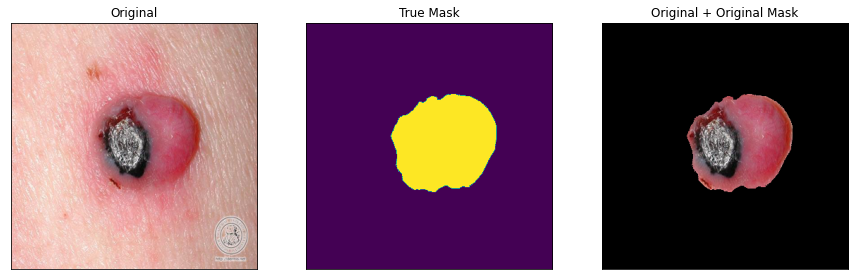

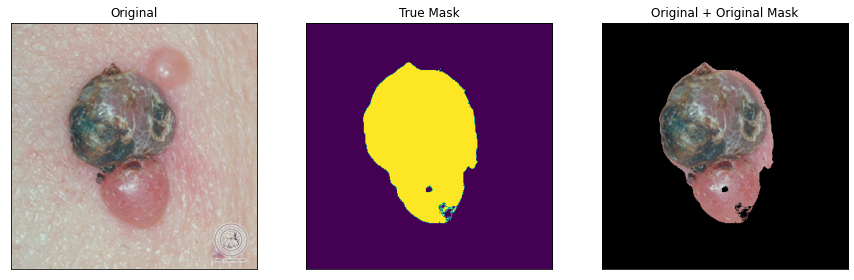

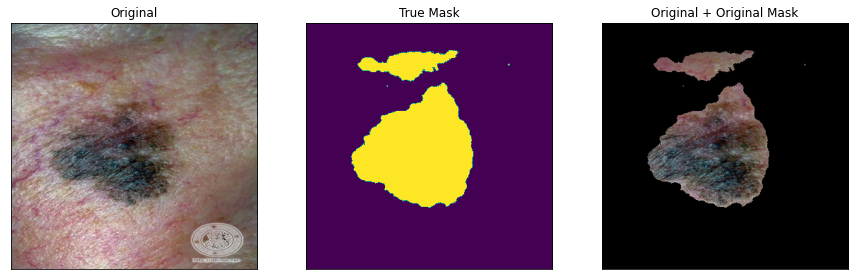

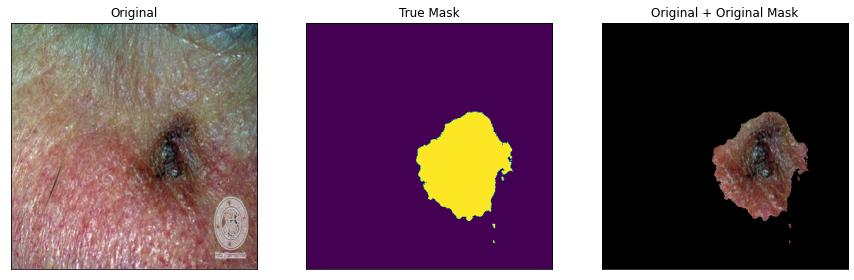

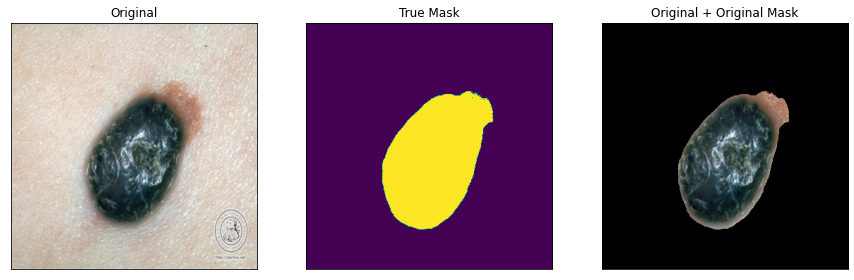

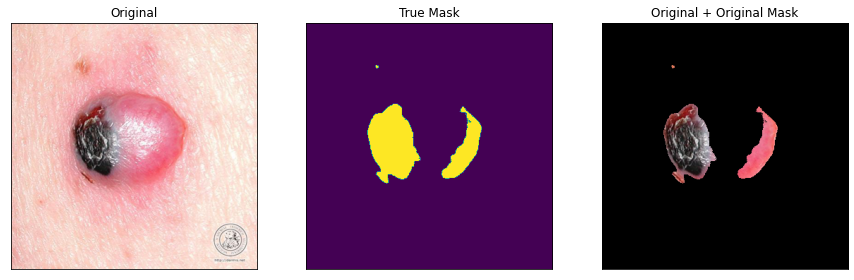

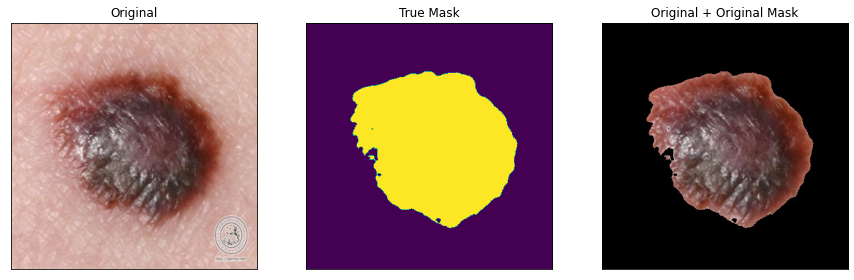

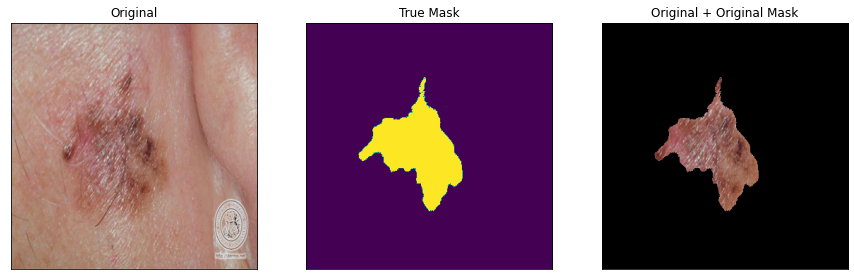

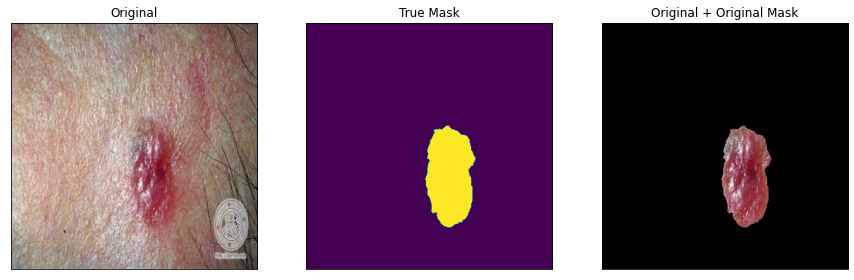

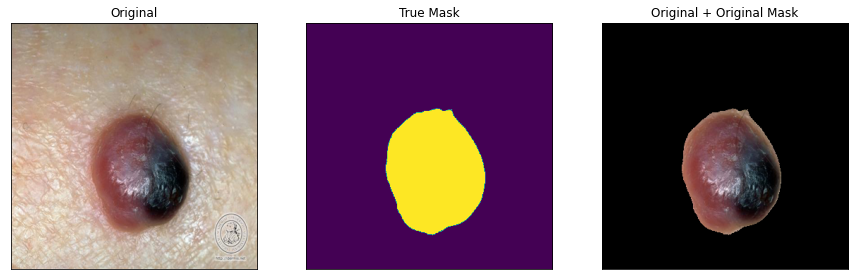

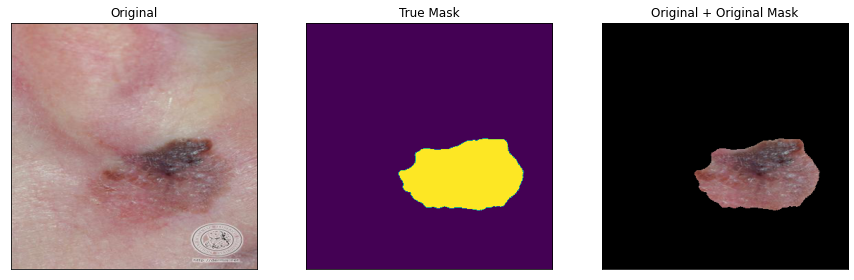

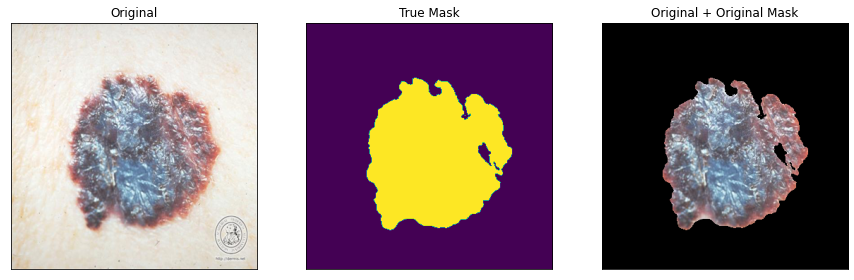

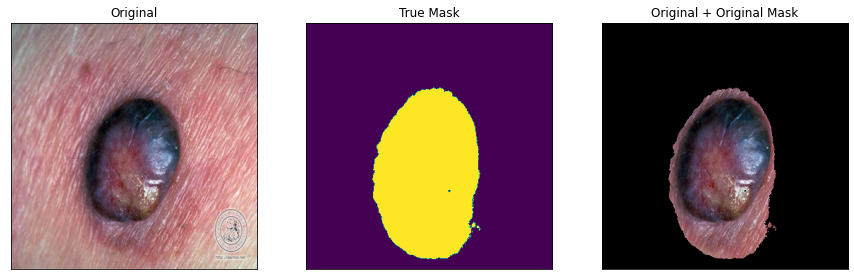

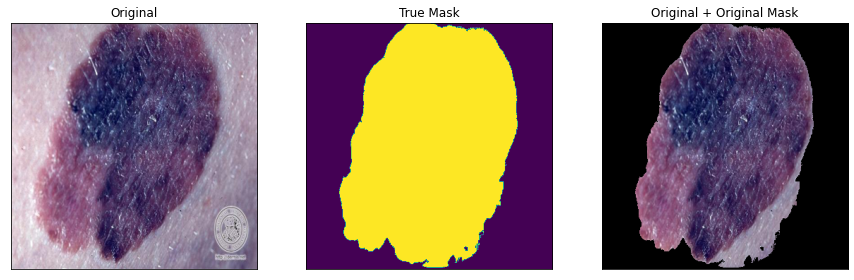

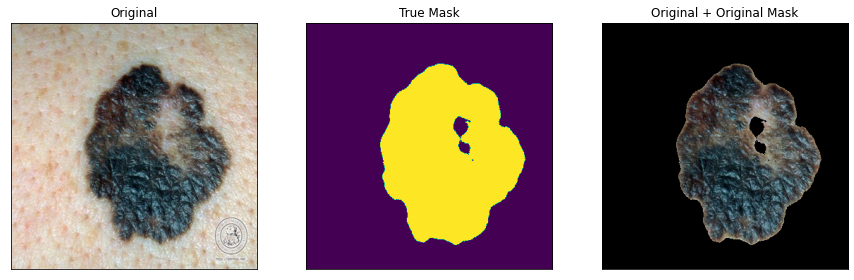

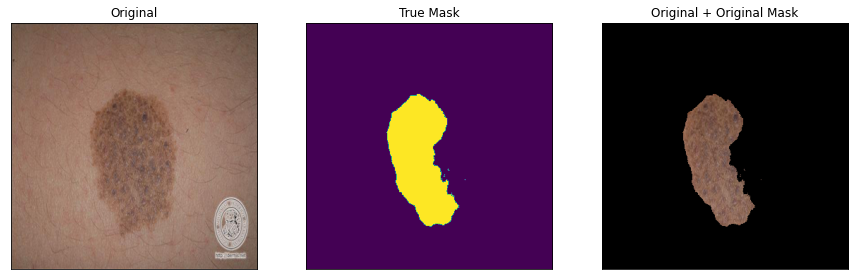

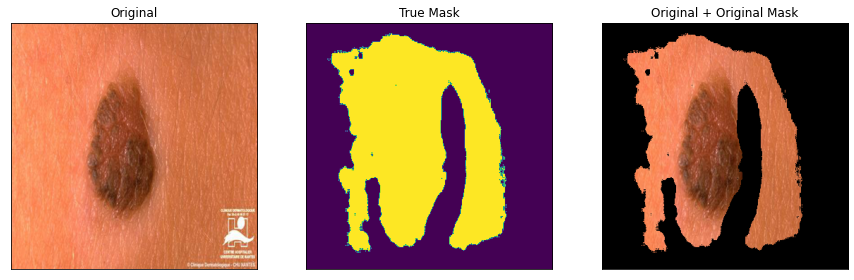

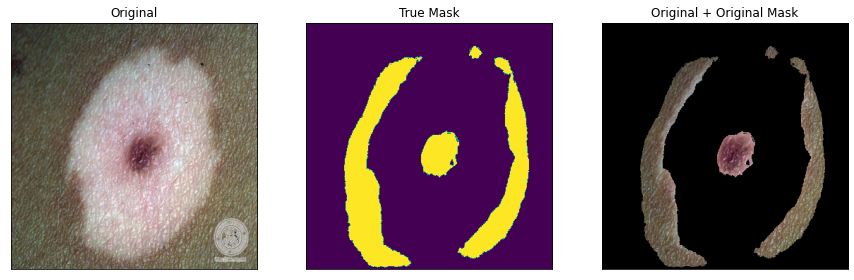

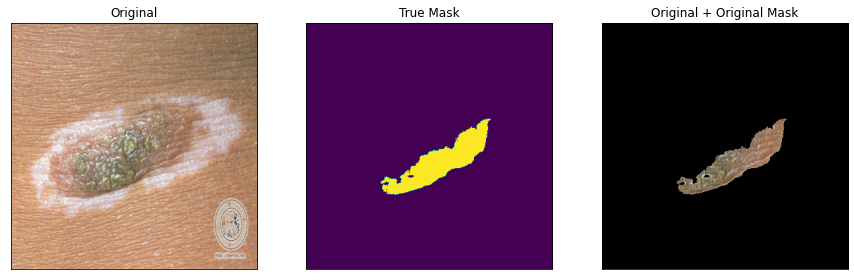

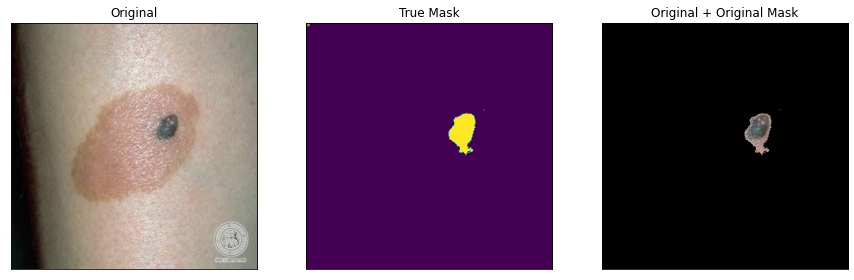

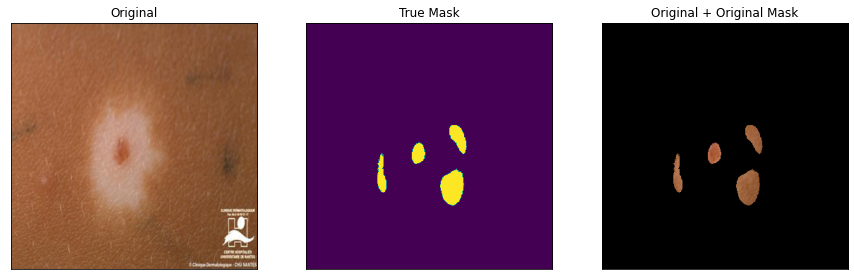

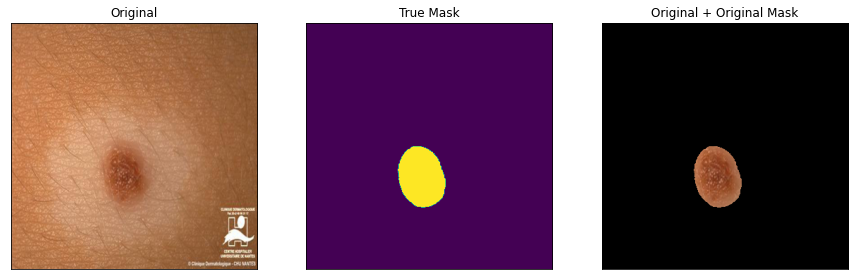

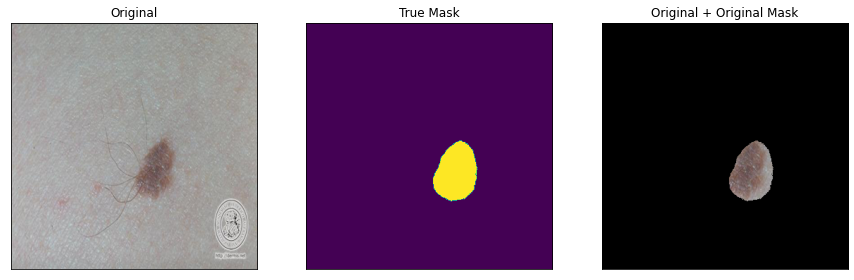

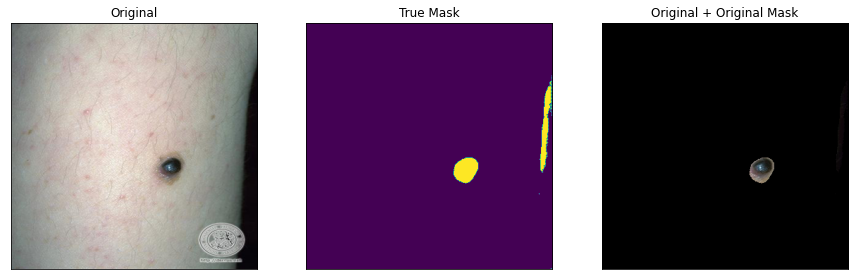

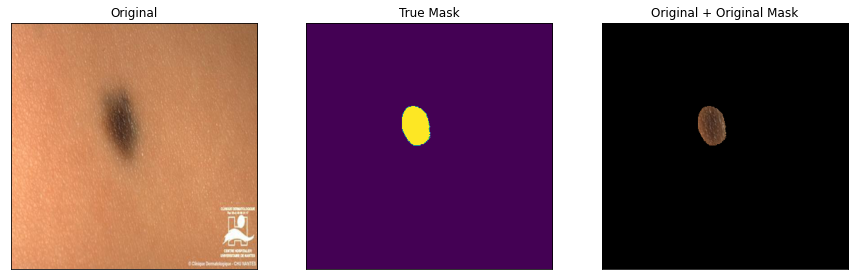

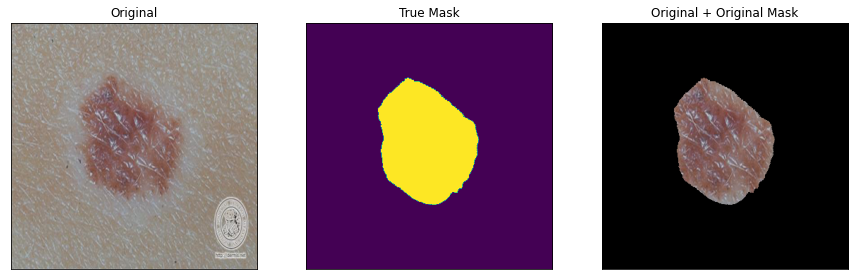

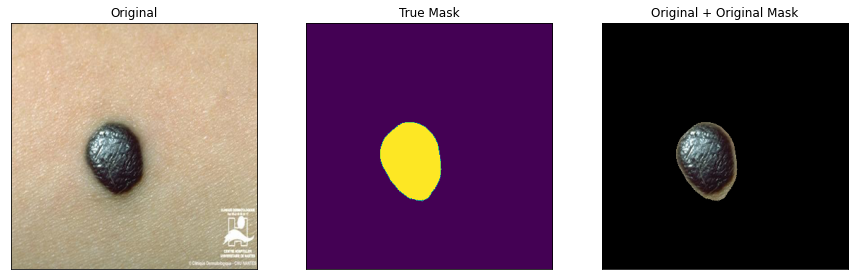

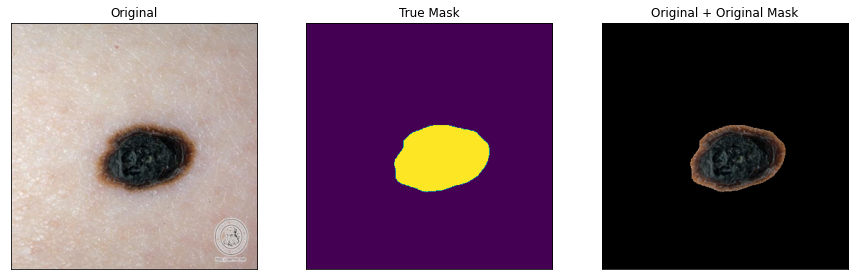

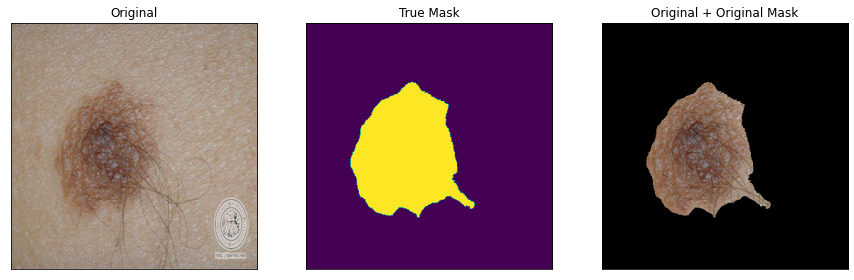

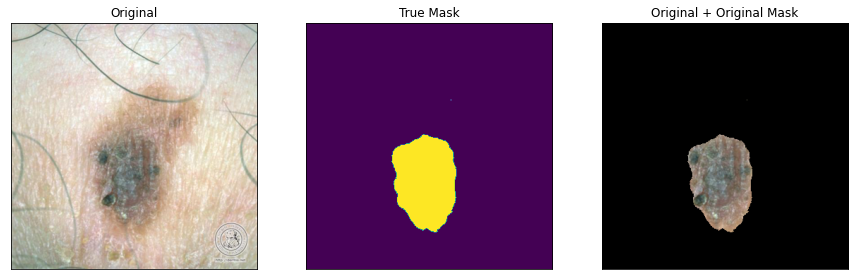

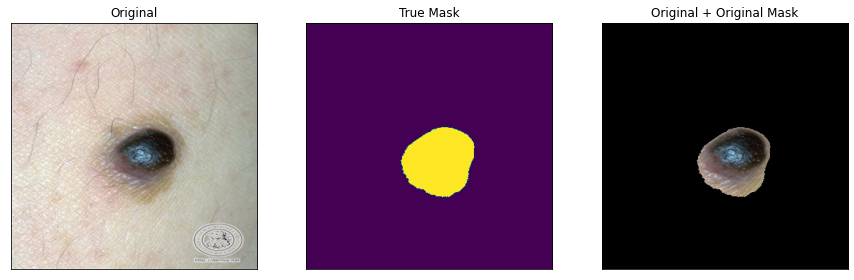

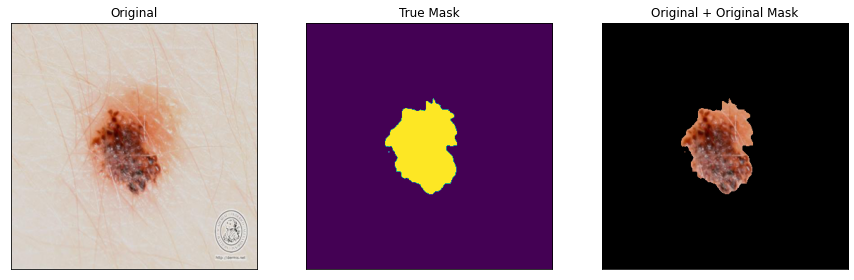

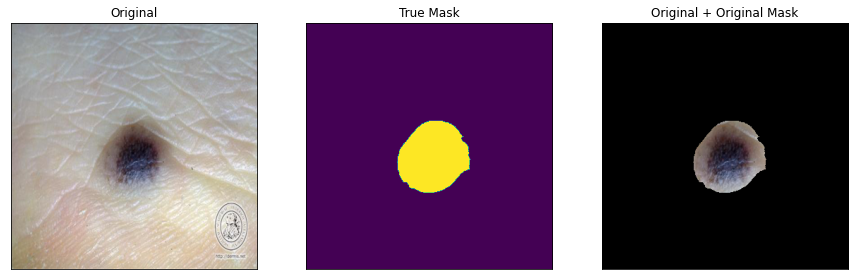

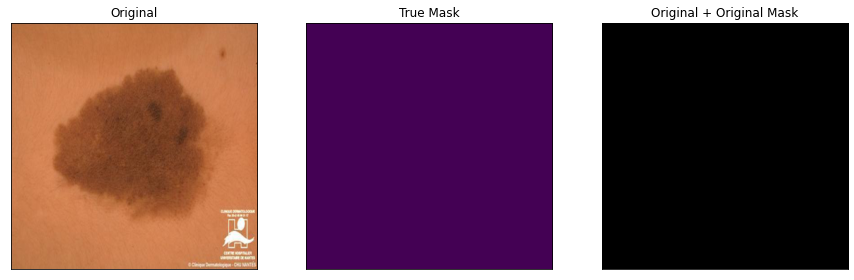

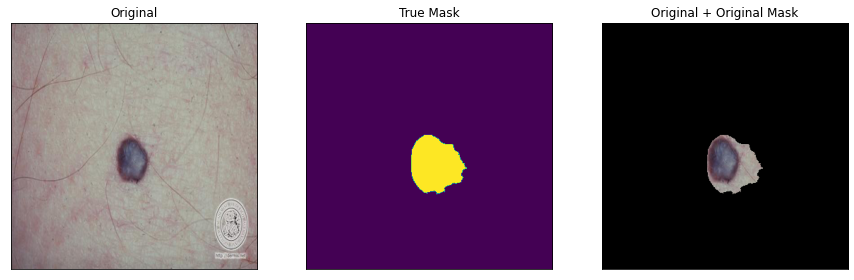

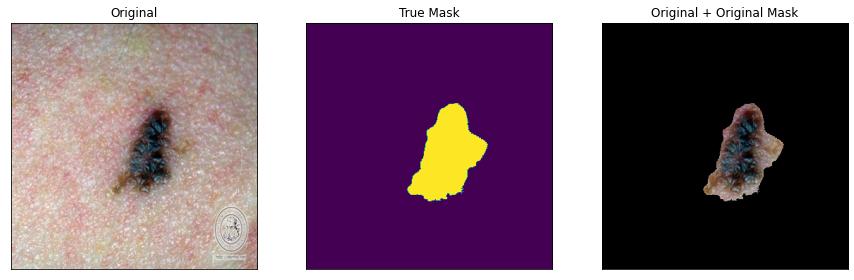

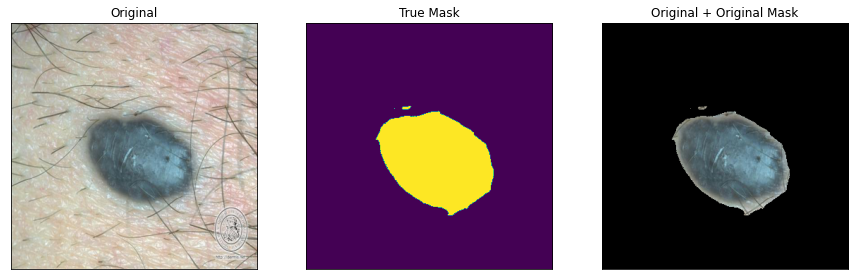

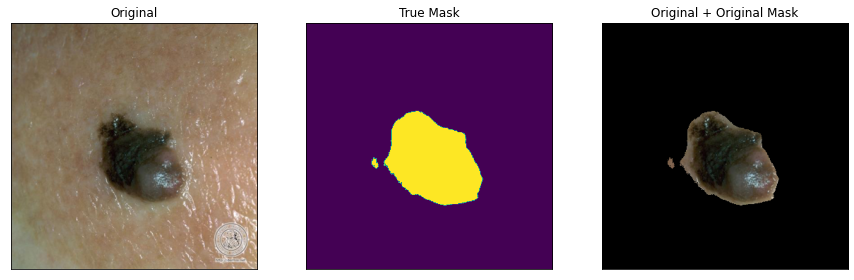

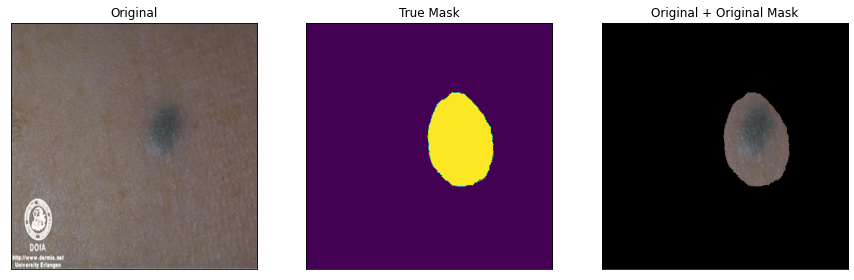

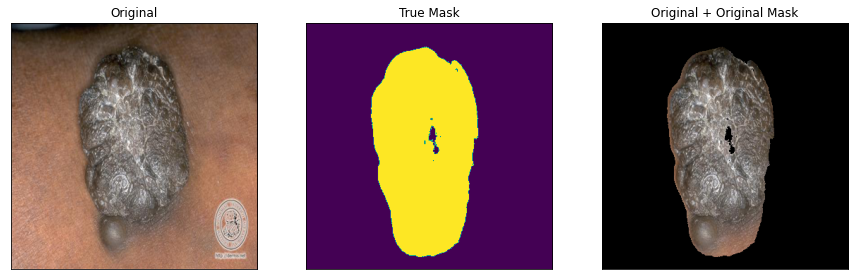

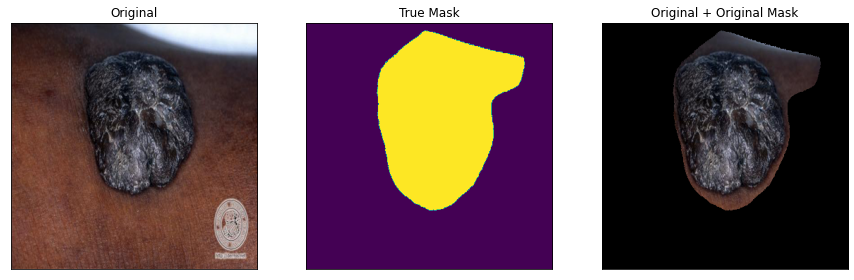

In [31]:
segment_lesions(val_loader, model, VAL_IMG_DIR)

In [ ]:
def segment_lesions(image_dir):
    images = os.listdir(image_dir)
    for image in images:
        img_path = os.path.join(image_dir, image)